In [2]:
import math
import numpy as np
import tomlkit
import pandas as pd
import yaml
from IPython.display import display
import importlib
import copy
import awkward as ak
import seaborn as sns
sns.set_theme()
import matplotlib
import matplotlib.pyplot as plt

import study_lib

In [3]:
importlib.reload(study_lib)
do_run = study_lib.do_run 
run_experiment = study_lib.run_experiment
config_series = study_lib.config_series

In [4]:
base_config_yaml = f"""
candidates: 4
voters: 2000
considerations:
- Issues:
    - halfcsep: 0.
      halfvsep: 0.
      sigma: {1./math.sqrt(3.)}
      uniform: true
methods:
- Plurality:
    strat: Honest
- Plurality:
    strat: Strategic
- InstantRunoff: {{}}
- Range:
    nranks: 2
    strat: Honest
- Range:
    nranks: 2
    strat: Strategic
- STAR:
    strat: Honest
- STAR:
    strat: Strategic
    strategic_stretch_factor: 2.0
- BtrIrv:
    strat: Honest
- RP:
    strat: Honest
"""
base_config = yaml.safe_load(base_config_yaml)

In [46]:
config = copy.deepcopy(base_config)
(df := run_experiment(config_series(config, 'candidates', [2, 3, 5, 8]), trials=50000,
                      with_results=True, show_output=False))
results = df.attrs["results"]

In [139]:
# rslt_5c = do_run(base_config, 10000)
(rslt_2c, rslt_3c, rslt_5c, rslt_8c) = results

In [5]:
rslt_2c = ak.from_parquet('ctr_sqz_1d_2c.parquet')
rslt_3c = ak.from_parquet('ctr_sqz_1d_3c.parquet')
rslt_5c = ak.from_parquet('ctr_sqz_1d_5c.parquet')
# rslt_8c = ak.from_parquet('ctr_sqz_1d_8c.parquet')
# rslt_13c = ak.from_parquet('ctr_sqz_1d_13c.parquet')

In [6]:
rslt_5c.fields

['ideal_cand',
 'cand_regret',
 'issues',
 'cov_matrix',
 'num_smith',
 'in_smith',
 'methods']

In [7]:
rslt_5c.methods.fields

['pl_h',
 'pl_s',
 'IRV_h',
 'aprv_h',
 'aprv_s',
 'star_6_h',
 'star_6_s',
 'BTR-IRV_h',
 'rp_h']

In [8]:
for idx, rslt in enumerate(results):
    ncand = len(rslt.issues[0, :, 0])
    print(f"resuts[{idx}]: {ncand=}")

NameError: name 'results' is not defined

In [9]:
rslt=rslt_2c
iss = rslt.issues[:,:,0]
ncand = len(rslt.issues[0, :, 0])
print(f"{ncand=}")
pl_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_h.winner]
aprv_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.aprv_h.winner]
pl_s_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_s.winner]
irv_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.IRV_h.winner]
all_iss = iss[np.arange(len(iss)), np.random.randint(0,ncand,len(iss))]
max_util = rslt.issues[:, 0, 0]

ncand=2


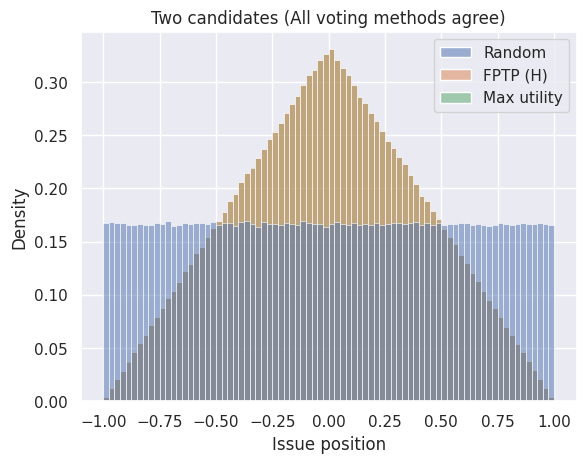

In [ ]:
sns.histplot({'Random':all_iss, 'FPTP (H)':pl_h_winner_iss, 'Max utility':max_util},
             binrange=(-1,1), bins=80, stat='density')
plt.title("Two candidates (All voting methods agree)")
plt.xlabel("Issue position")
plt.savefig("plots/oneissue_twocand.png")

ncand=5


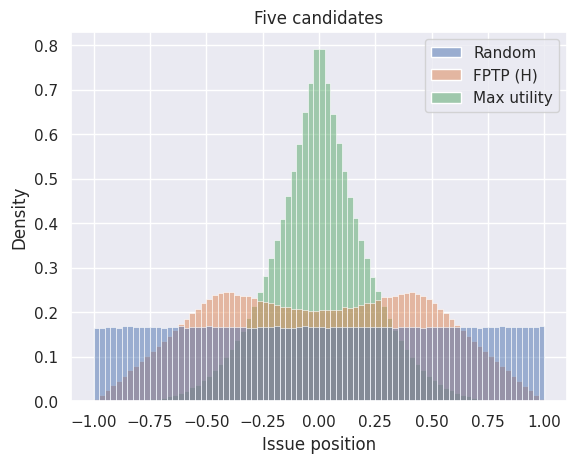

In [ ]:
rslt=rslt_5c
iss = rslt.issues[:,:,0]
ncand = len(rslt.issues[0, :, 0])
print(f"{ncand=}")
pl_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_h.winner]
aprv_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.aprv_h.winner]
pl_s_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_s.winner]
irv_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.IRV_h.winner]
all_iss = iss[np.arange(len(iss)), np.random.randint(0,ncand,len(iss))]
max_util = rslt.issues[:, 0, 0]
sns.histplot({'Random':all_iss, 'FPTP (H)':pl_h_winner_iss, 'Max utility':max_util},
             binrange=(-1,1), bins=80, stat='density')
plt.title("Five candidates")
plt.xlabel("Issue position")
plt.savefig("plots/oneissue_5cand_fptp_hist.png")

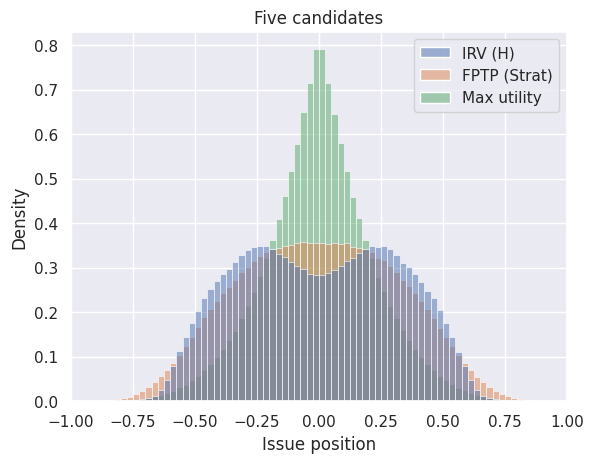

In [ ]:
sns.histplot({'IRV (H)':irv_h_winner_iss, 'FPTP (Strat)':pl_s_winner_iss, 'Max utility':max_util},
             binrange=(-1,1), bins=80, stat='density')
plt.title("Five candidates")
plt.xlabel("Issue position")
plt.xlim([-1,1])
plt.savefig("plots/oneissue_5cand_ftpts_irv_hist.png")

In [148]:
ak.count_nonzero(rslt_5c.in_smith[np.arange(len(iss)), rslt_5c.methods.aprv_h.winner])

np.int64(1554390)

In [149]:
ak.count_nonzero(rslt_5c.num_smith < 3)

np.int64(2000000)

In [150]:
ak.count_nonzero(rslt_5c.in_smith[np.arange(len(iss)), rslt_5c.methods["BTR-IRV_h"].winner]) 

np.int64(2000000)

In [151]:
rslt_5c.methods.fields

['pl_h',
 'pl_s',
 'IRV_h',
 'aprv_h',
 'aprv_s',
 'star_6_h',
 'star_6_s',
 'BTR-IRV_h',
 'rp_h']

In [152]:
ak.count_nonzero(rslt_5c.in_smith[np.arange(len(iss)), rslt_5c.methods["rp_h"].winner])

np.int64(2000000)

In [13]:
def hist_1d_issue(rslt, method, ax=None, nbins=40, title="", y2lims=None):
    ncand = len(rslt.issues[0, :, 0])
    if ax is None:
        _, ax = plt.subplots(1, 1)
    iss = rslt.issues[:,:,0]
    winner_iss = iss[np.arange(len(iss)), rslt.methods[method].winner]
    best_iss = rslt.issues[:, 0, 0]
    winner_hist, bin_edges = np.histogram(winner_iss, bins=nbins, range=(-1,1))
    best_hist, _ = np.histogram(best_iss, bins=nbins, range=(-1,1))
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    winner_dist_ratio = winner_hist / best_hist
    best_theory = (1. - np.abs(bin_edges))**ncand
    best_theory = np.abs(best_theory[1:] - best_theory[:-1]) / 2 / bin_width
    sns.histplot(winner_iss, binrange=(-1,1), bins=nbins, stat='density', ax=ax, label="winner dist'n")
    ax.plot(bin_centers, best_theory, 'P', markersize=3, c='C1', label="theory, ∞ voters")
    ax.set_xlim([-1, 1])
    ax2 = ax.twinx()
    ax2.semilogy(bin_centers, winner_dist_ratio, '.-', label="winners / max_util", c="C5")
    ax2.set_ylabel("Ratio winner / best candidate")
    ax2.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.tick_params(axis='y', which="both", colors='C5')
    #ax2.yaxis.label.set_color("C4")
    if y2lims:
        ax2.set_ylim(y2lims)
    ax.grid(which="major", axis="y")  # is this a bug?
    ax2.grid(which="minor", axis="y")  # or is it this one?
    ax.set_xlabel("Issue position")
    if title:
        plt.title(title)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper right")

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


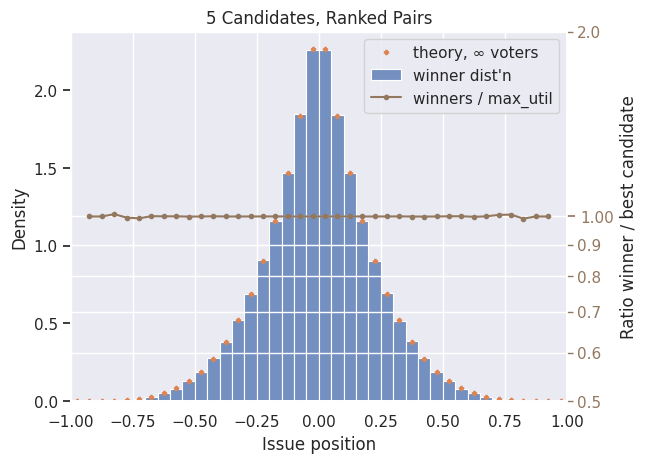

In [ ]:
hist_1d_issue(rslt_5c, 'rp_h', nbins=40, title='5 Candidates, Ranked Pairs', y2lims=(.5,2.0))

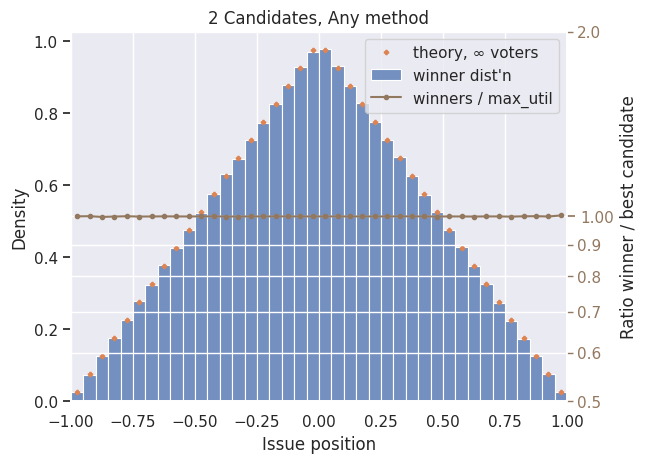

In [14]:
hist_1d_issue(rslt_2c, 'rp_h', nbins=40, title='2 Candidates, Any method', y2lims=(.5,2.0))
plt.savefig("plots/oneissue_twocand_ratio.png")

In [156]:
rp_h_2c_misses = rslt_2c[rslt_2c.methods.rp_h.winner != rslt_2c.ideal_cand]
print(f"{len(rp_h_2c_misses)=}")
ak.to_list(rp_h_2c_misses[0])

len(rp_h_2c_misses)=1899


{'ideal_cand': 0,
 'cand_regret': [0.0, 2.0000000000003944],
 'issues': [[0.180905824372681], [-0.1934603470135121]],
 'cov_matrix': [[0.09942264309155718],
  [0.039394673143931094, 0.10197912447560953]],
 'num_smith': 1,
 'in_smith': [False, True],
 'methods': {'pl_h': {'winner': 1, 'regret': 2.0000000000003944},
  'pl_s': {'winner': 1, 'regret': 2.0000000000003944},
  'IRV_h': {'winner': 1, 'regret': 2.0000000000003944},
  'aprv_h': {'winner': 1, 'regret': 2.0000000000003944},
  'aprv_s': {'winner': 1, 'regret': 2.0000000000003944},
  'star_6_h': {'winner': 1, 'regret': 2.0000000000003944},
  'star_6_s': {'winner': 1, 'regret': 2.0000000000003944},
  'BTR-IRV_h': {'winner': 1, 'regret': 2.0000000000003944},
  'rp_h': {'winner': 1, 'regret': 2.0000000000003944}}}

In [157]:
ak.to_list(rp_h_2c_misses[3])

{'ideal_cand': 0,
 'cand_regret': [0.0, 2.0],
 'issues': [[-0.9307940768059751], [0.9374799873924842]],
 'cov_matrix': [[0.3293889661990392],
  [-0.32954164787961143, 0.3300671920852007]],
 'num_smith': 1,
 'in_smith': [False, True],
 'methods': {'pl_h': {'winner': 1, 'regret': 2.0},
  'pl_s': {'winner': 1, 'regret': 2.0},
  'IRV_h': {'winner': 1, 'regret': 2.0},
  'aprv_h': {'winner': 1, 'regret': 2.0},
  'aprv_s': {'winner': 1, 'regret': 2.0},
  'star_6_h': {'winner': 1, 'regret': 2.0},
  'star_6_s': {'winner': 1, 'regret': 2.0},
  'BTR-IRV_h': {'winner': 1, 'regret': 2.0},
  'rp_h': {'winner': 1, 'regret': 2.0}}}

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


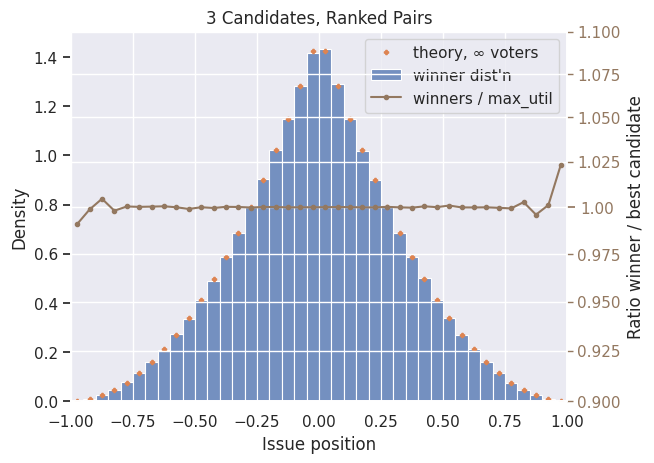

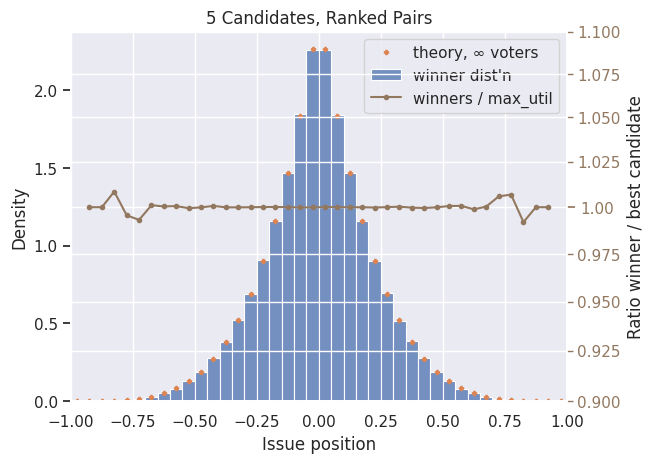

In [16]:
hist_1d_issue(rslt_3c, 'rp_h', nbins=40, title='3 Candidates, Ranked Pairs', y2lims=(.9,1.1))
plt.savefig("plots/oneissue_rp_5c.png")
hist_1d_issue(rslt_5c, 'rp_h', nbins=40, title='5 Candidates, Ranked Pairs', y2lims=(.9,1.1))
plt.savefig("plots/oneissue_rp_5c.png")

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


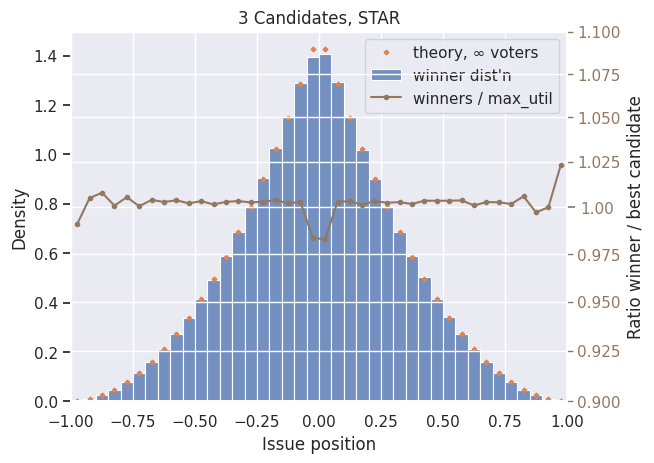

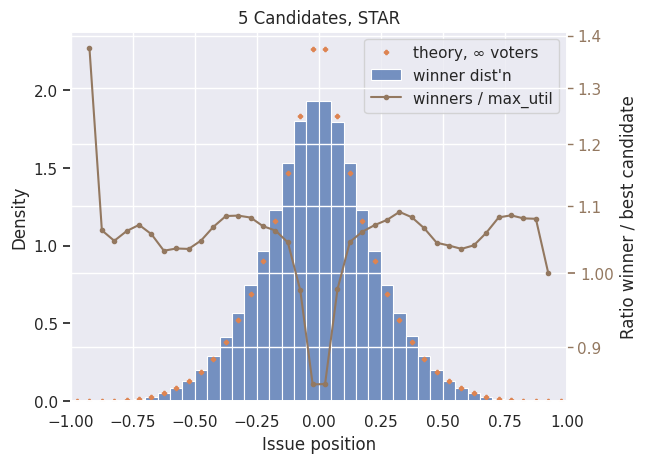

In [20]:
hist_1d_issue(rslt_3c, 'star_6_h', nbins=40, title='3 Candidates, STAR', y2lims=(.9,1.1))
plt.savefig("plots/oneissue_star_3c.png")
hist_1d_issue(rslt_5c, 'star_6_h', nbins=40, title='5 Candidates, STAR') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_star_5c.png")

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


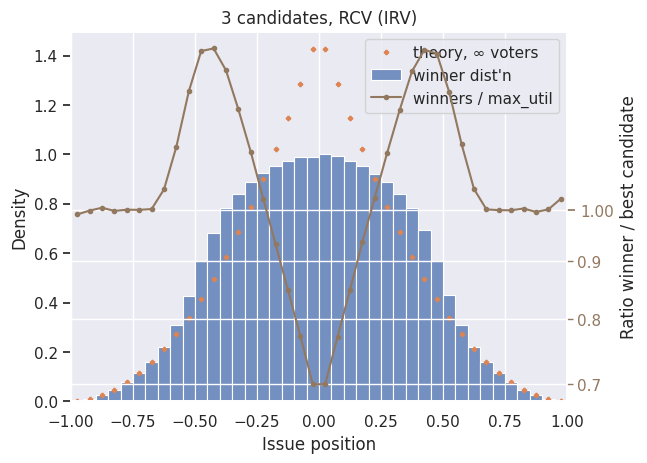

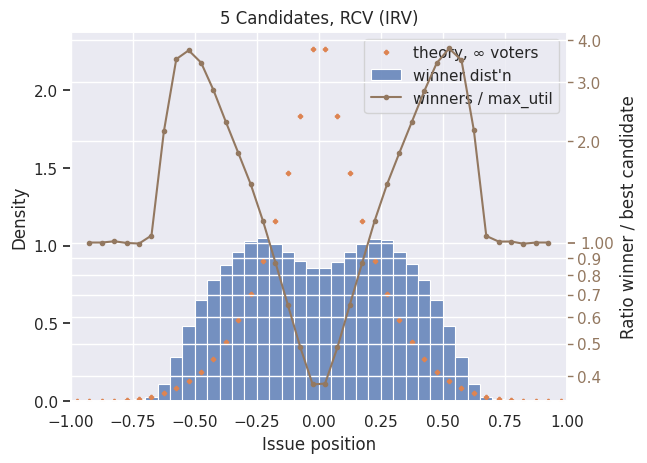

In [ ]:
hist_1d_issue(rslt_3c, 'IRV_h', nbins=40, title="3 Candidates, RCV (IRV)")
plt.savefig("plots/oneissue_irv_3c.png")
hist_1d_issue(rslt_5c, 'IRV_h', nbins=40, title='5 Candidates, RCV (IRV)') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_irv_5c.png")

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


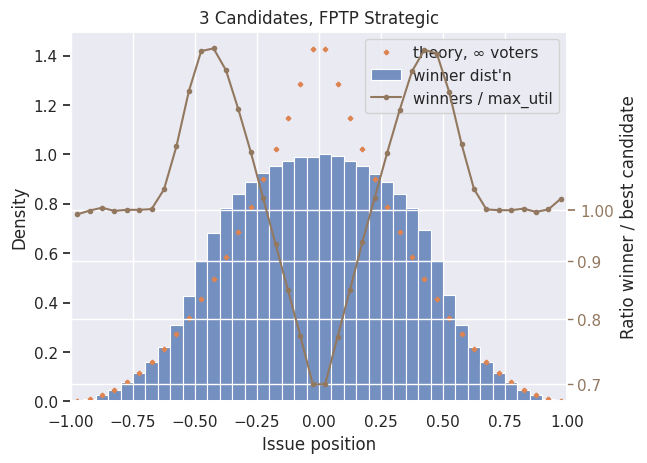

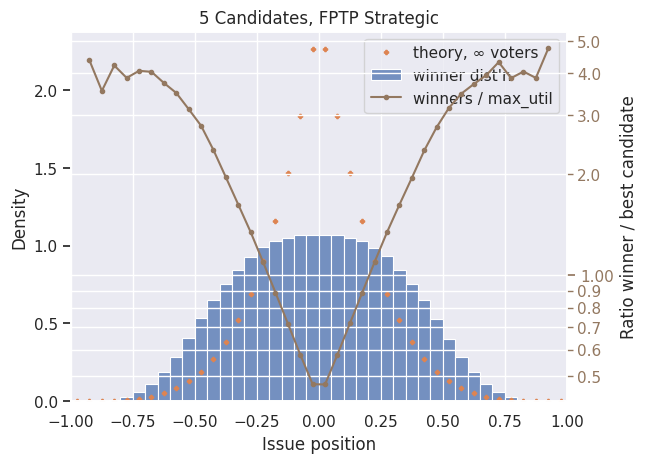

In [25]:
hist_1d_issue(rslt_3c, 'pl_s', nbins=40, title="3 Candidates, FPTP Strategic")
plt.savefig("plots/oneissue_fptps_3c.png")
hist_1d_issue(rslt_5c, 'pl_s', nbins=40, title='5 Candidates, FPTP Strategic') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_fptps_5c.png")

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


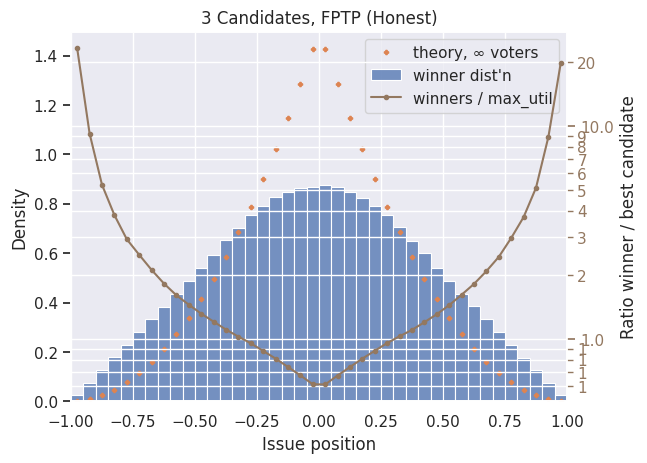

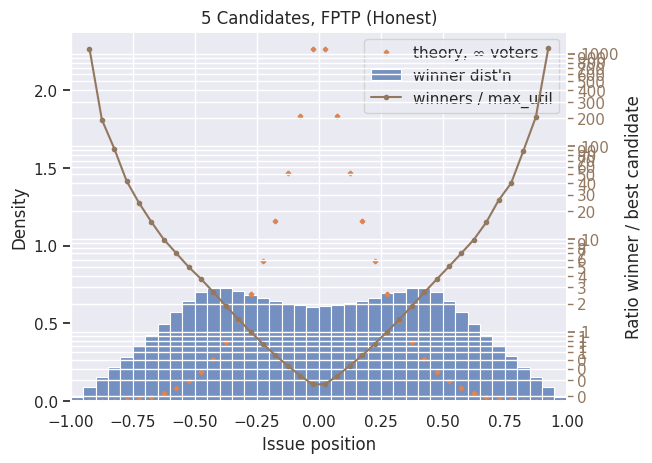

In [28]:
hist_1d_issue(rslt_3c, 'pl_h', nbins=40, title="3 Candidates, FPTP (Honest)")
plt.savefig("plots/oneissue_fptph_3c.png")
hist_1d_issue(rslt_5c, 'pl_h', nbins=40, title='5 Candidates, FPTP (Honest)') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_fptph_5c.png")

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


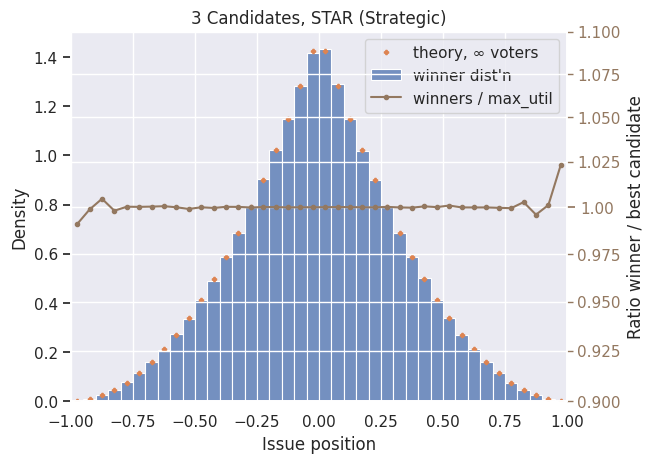

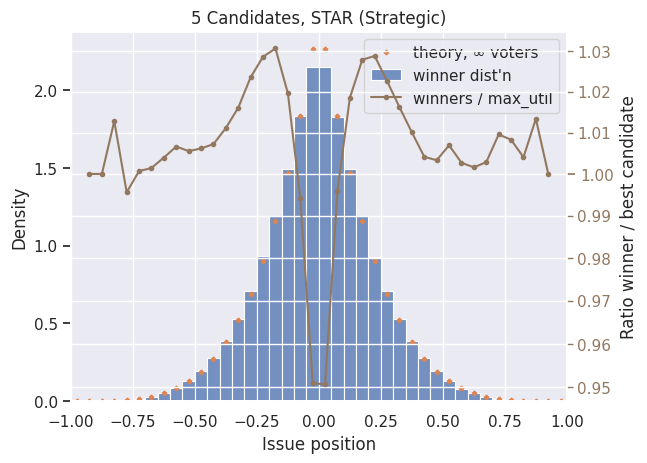

In [29]:
hist_1d_issue(rslt_3c, 'star_6_s', nbins=40, title='3 Candidates, STAR (Strategic)', y2lims=(.9,1.1))
plt.savefig("plots/oneissue_stars_3c.png")
hist_1d_issue(rslt_5c, 'star_6_s', nbins=40, title='5 Candidates, STAR (Strategic)') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_stars_5c.png")

/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/home/topher/git/vote-sim-studies/.venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


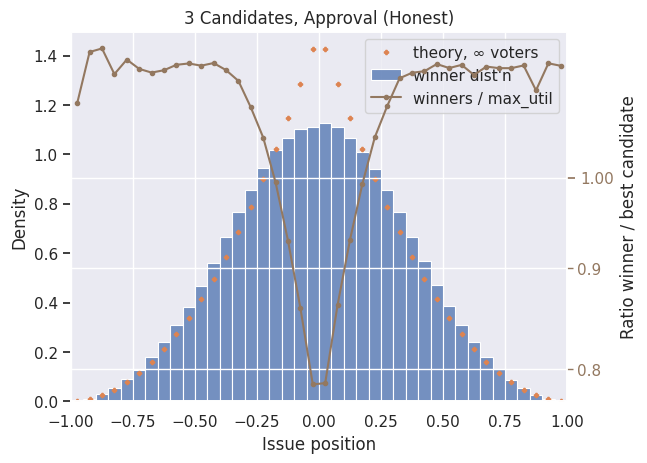

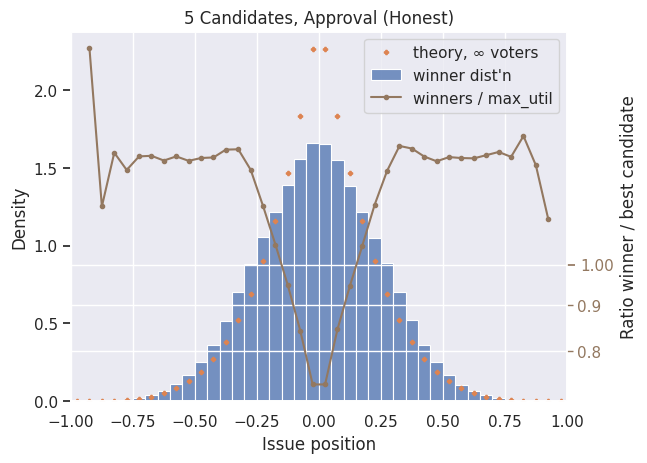

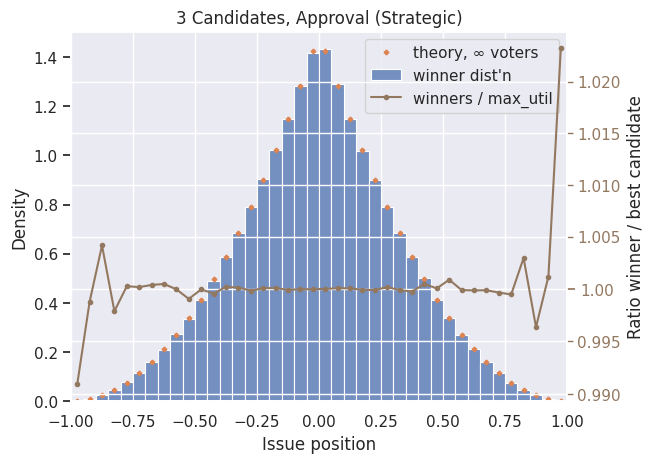

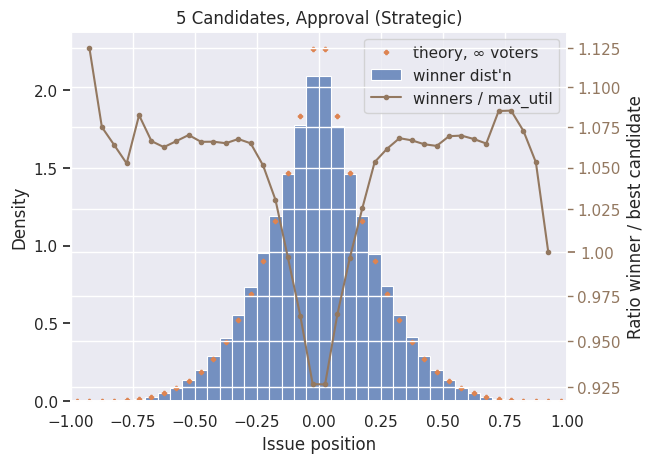

In [31]:
hist_1d_issue(rslt_3c, 'aprv_h', nbins=40, title='3 Candidates, Approval (Honest)') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_aprv_3c.png")
hist_1d_issue(rslt_5c, 'aprv_h', nbins=40, title='5 Candidates, Approval (Honest)') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_aprv_5c.png")
hist_1d_issue(rslt_3c, 'aprv_s', nbins=40, title='3 Candidates, Approval (Strategic)') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_aprvs_3c.png")
hist_1d_issue(rslt_5c, 'aprv_s', nbins=40, title='5 Candidates, Approval (Strategic)') #, y2lims=(.9,1.1))
plt.savefig("plots/oneissue_aprvs_5c.png")